Author of code: William Godel 

Date: 07/02

Purpose: to analize feature importance of some models

## Data IN: 

X_train_stand.p

Y_data.p

X_val_stand.p

Y_data_val.p

X_train_stand_large.p

test_target_large.p

model_large.pt
 
X_data_pol_test.p

X_data_pol_orig.p

model_nn_highpol.pt


## Data OUT: 

percentage_change_pol.pt


Machine: My laptop or Imac

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import Counter
laptop = True
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from functions import count_mode, bayes_probs, bayes_binary
from ml_functions import feature_creation, conf_eval, data_prep, test_model

from sklearn.model_selection import train_test_split

import shap

from path import *

In [2]:
X_train_stand = pickle.load(open(data_pickles + 'X_train_stand.p', "rb" ))
Y_data = pickle.load(open(data_pickles + 'Y_data.p', "rb" ))

X_val_stand = pickle.load(open(data_pickles + 'X_val_stand.p', "rb" ))
Y_data_val = pickle.load(open(data_pickles + 'Y_data_val.p', "rb" ))

X_test_stand_large = pickle.load(open(data_pickles + 'X_test_stand_large.p', "rb" ))
test_target_large = pickle.load(open(data_pickles + 'test_target_large.p', "rb" ))


In [3]:
numeric_features = []

resp_var = [x for x in X_train_stand.columns if 'resp_veracity_' in x]
new_cols = [x for x in X_train_stand.columns if 'new' in x]

#numeric_features.extend(resp_var)
numeric_features.extend(resp_var) #rempve this if it doesn't work
numeric_features.extend(new_cols)
numeric_features.extend(["crowd_means",'crowd_median','crowd_full_range', 'crowd_IQR_range', \
                         'crowd_variance', 'crowd_bayes'])

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(emb_dim, 500) 
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 25)
        self.fc4 = nn.Linear(25, 25)
        self.fc5 = nn.Linear(25, 10)
        self.fc6 = nn.Linear(10, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        
        return x



In [5]:
rand_cols = ['crowd_means',
 'crowd_median',
 'crowd_full_range',
 'crowd_IQR_range',
 'crowd_variance',
 'crowd_bayes',
 'new_crowd_t',
 'new_crowd_f',
 'new_crowd_c',
 'new_t_f',
 'new_t_f_d',
 'new_c_dif',
 'new_t_dif',
 'new_f_dif',
 'new_c_per',
 'new_t_per',
 'new_f_per',
 'new_f_rat',
 'new_t_rat',
'crowd_mode_f',
 'crowd_mode_t']

In [6]:
feature_dic= {}

emb_dim = 121   
net_large = Net(emb_dim)
net_large.load_state_dict(torch.load(models + "model_large.pt"))
net_large.eval()

num_sim = 100

for a_col in rand_cols:
    
    perf_list = []
    
    for sim in range(num_sim):
    
        x_stand_rand = X_test_stand_large.copy()

        array_target_test = np.array(x_stand_rand[a_col])

        np.random.shuffle(array_target_test)

        x_stand_rand[a_col] = array_target_test

        train_dat_nn_large = data_prep(x_stand_rand,test_target_large)

        nn_preds  = torch.sigmoid(net_large(torch.tensor(train_dat_nn_large[:][0]).float()))
        nn_preds = np.where(nn_preds > .5, 1,0).reshape(-1,)

        all_results = list(conf_eval(nn_preds, test_target_large))
        
        perf_list.append(all_results[0])

    feature_dic[a_col] = np.mean(perf_list)

<BarContainer object of 21 artists>

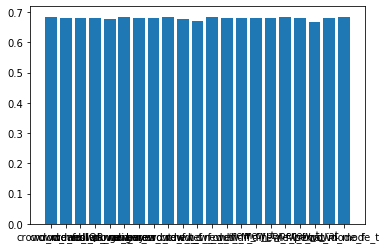

In [7]:
keys_large = feature_dic.keys()
values_large = feature_dic.values()
plt.bar(keys_large,values_large)

## NN high pol

In [8]:
X_data_pol_test = pd.read_pickle(data_pickles + 'pol_knowledge_df_test.p')
X_data_pol_orig = pd.read_pickle(data_pickles + 'pol_knowledge_df_train_orig.p')

In [9]:
X_data_pol_test = feature_creation(X_data_pol_test)
X_data_pol_orig = feature_creation(X_data_pol_orig)

In [10]:
covert_names_dic = {"True minus False": "new_t_f",
"True to False Ratio": "new_t_f_d",
"CND minus True and False": "new_c_dif",
"True minus CND and False": "new_t_dif",
"False minus True and CND": "new_f_dif",
"Percentage CND": "new_c_per",
"Percentage True": "new_t_per",
"Percentage False": "new_f_per",
"Ratio of False and CND to True" : "new_f_rat",
"Ratio of True and CND to False" : "new_t_rat",
"Number True": "new_crowd_t",
"Number False": "new_crowd_f",
"Number CND": "new_crowd_c",
"Full Range of Crowd":"crowd_full_range",
"IQR Range of Crowd":"crowd_IQR_range",
"Crowd Mean":"crowd_means",
"Crowd Median": "crowd_median",
"Crowd Variance": "crowd_variance",
"Crowd Bayes":"crowd_bayes",
"Ideology of Respondent 7":"ideology_resp_7",
"Veracity Score of Respondent 8":"resp_veracity_8",
"Veracity Score of Respondent 6":"resp_veracity_6",
"Mode of Crowd T":"crowd_mode_t",
"Mode of Crowd F":"crowd_mode_f",}


covert_names_dic = {k:v for v,k in covert_names_dic.items()}
    

In [11]:
numeric_features = []

resp_var = [x for x in X_data_pol_test.columns if 'resp_veracity_' in x]
new_cols = [x for x in X_data_pol_test.columns if 'new' in x]

numeric_features.extend(resp_var) 
numeric_features.extend(new_cols)
numeric_features.extend(["crowd_means",'crowd_median','crowd_full_range', 'crowd_IQR_range', \
                         'crowd_variance', 'crowd_bayes'])

In [12]:
feature_dic_highpol= {}

emb_dim = 61 
net_highpol = Net(emb_dim)
net_highpol.load_state_dict(torch.load(models + "model_nn_highpol.pt"))
net_highpol.eval()

num_sim = 100


test = StandardScaler()
test.fit(X_data_pol_orig[numeric_features])

#training data
X_test_stand_large = X_data_pol_test.copy()
X_test_stand_large[numeric_features] = test.transform(X_data_pol_test[numeric_features])

for a_col in rand_cols:
    
    perf_list = []
    
    for sim in range(num_sim):
    
        x_stand_rand = X_test_stand_large.copy()

        array_target_test = np.array(x_stand_rand[a_col])

        np.random.shuffle(array_target_test)

        x_stand_rand[a_col] = array_target_test

        train_dat_nn_large = data_prep(x_stand_rand,test_target_large)

        nn_preds  = torch.sigmoid(net_highpol(torch.tensor(train_dat_nn_large[:][0]).float()))
        nn_preds = np.where(nn_preds > .5, 1,0).reshape(-1,)

        all_results = list(conf_eval(nn_preds, test_target_large))
        
        perf_list.append(all_results[0])

    feature_dic_highpol[a_col] = np.mean(perf_list)

In [13]:
df_high_pol = pd.Series(feature_dic_highpol).sort_values()

In [14]:
# Best performance is 0.6785714285714286
#total change in performance is 0.1070714285714286

percentage_change_pol = (0.6785714285714286 - df_high_pol)/0.1070714285714286

In [15]:
pickle.dump(percentage_change_pol, open(data_pickles +  "percentage_change_pol.p", "wb" ) )

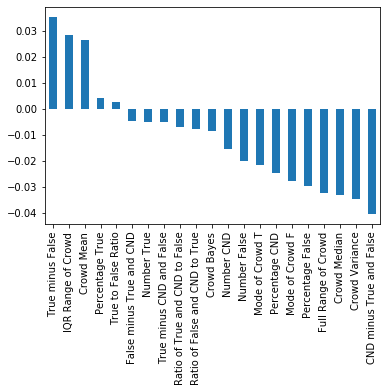

In [16]:
percentage_change_pol.rename(index = covert_names_dic, inplace = True)
percentage_change_pol.plot(kind = 'bar')
plt.savefig(figures + 'permutation_bars.pdf', dpi = 300, bbox_inches = 'tight')

# Shap values

In [17]:

covert_names_dic = {"True minus False": "new_t_f",
"True to False Ratio": "new_t_f_d",
"CND minus True and False": "new_c_dif",
"True minus CND and False": "new_t_dif",
"False minus True and CND": "new_f_dif",
"Percentage CND": "new_c_per",
"Percentage True": "new_t_per",
"Percentage False": "new_f_per",
"Ratio of False and CND to True" : "new_f_rat",
"Ratio of True and CND to False" : "new_t_rat",
"Number True": "new_crowd_t",
"Number False": "new_crowd_f",
"Number CND": "new_crowd_c",
"Full Range of Crowd":"crowd_full_range",
"IQR Range of Crowd":"crowd_IQR_range",
"Crowd Mean":"crowd_means",
"Crowd Median": "crowd_median",
"Crowd Variance": "crowd_variance",
"Crowd Bayes":"crowd_bayes",
"Ideology of Respondent 7":"ideology_resp_7",
"Veracity Score of Respondent 8":"resp_veracity_8",
"Veracity Score of Respondent 6":"resp_veracity_6"}


covert_names_dic = {k:v for v,k in covert_names_dic.items()}
    

In [18]:
test_data = data_prep(X_test_stand_large,test_target_large)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000,
                                          shuffle=True, num_workers=2)
batch = next(iter(test_loader))
data1, _ = batch
e = shap.DeepExplainer(net_highpol, data1.float())
shap_values = e.shap_values(data1.float())

#batch2 = next(iter(test_loader))
#data2, _ = batch2
graph_data = pd.DataFrame(data1.numpy(), columns = X_test_stand_large.columns)

In [19]:
graph_data.rename(columns=covert_names_dic, inplace = True)

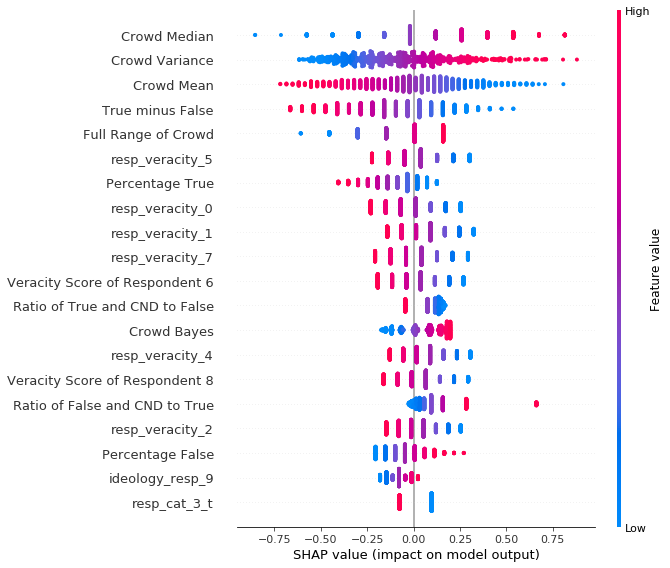

In [20]:
shap.summary_plot(shap_values,  graph_data, show = False)
plt.savefig(figures + 'shap_highpk.pdf', dpi = 300, bbox_inches = 'tight')

In [21]:
data1.shape

torch.Size([1000, 61])

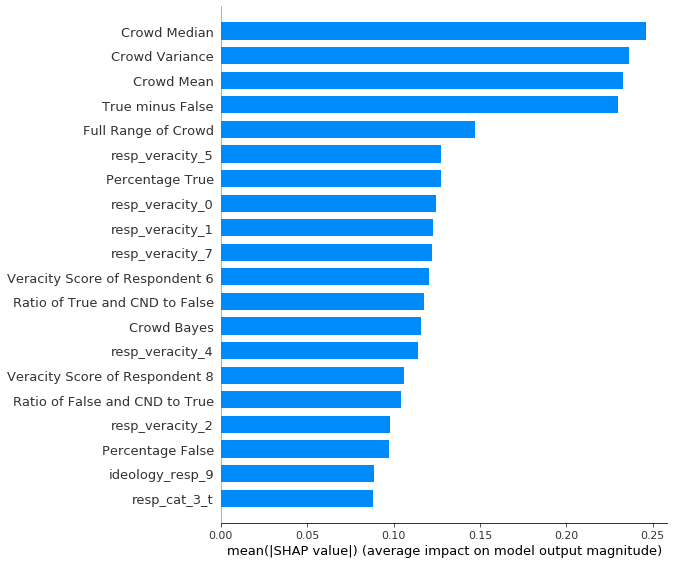

In [22]:
shap.summary_plot(shap_values,  graph_data, plot_type="bar")

# Large NN Shap values

In [23]:
numeric_features_large = []

resp_var = [x for x in X_test_stand_large.columns if 'resp_veracity_' in x]
new_cols = [x for x in X_test_stand_large.columns if 'new' in x]

#numeric_features.extend(resp_var)
numeric_features_large.extend(resp_var) #rempve this if it doesn't work
numeric_features_large.extend(new_cols)
numeric_features_large.extend(["crowd_means",'crowd_median','crowd_full_range', 'crowd_IQR_range', \
                         'crowd_variance', 'crowd_bayes'])

In [24]:
emb_dim = 121   
net_large = Net(emb_dim)
net_large.load_state_dict(torch.load(models + "model_large.pt"))
net_large.eval()

Net(
  (fc1): Linear(in_features=121, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=25, bias=True)
  (fc5): Linear(in_features=25, out_features=10, bias=True)
  (fc6): Linear(in_features=10, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
)

In [25]:
X_test_stand_large = pickle.load(open(data_pickles + 'X_train_stand_large.p', "rb" ))
test_data = data_prep(X_test_stand_large,test_target_large)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000,
                                          shuffle=True, num_workers=2)

batch = next(iter(test_loader))
data1, _ = batch
e = shap.DeepExplainer(net_large, data1.float())
shap_values = e.shap_values(data1.float())

#batch2 = next(iter(test_loader))
#data2, _ = batch2
graph_data = pd.DataFrame(data1.numpy(), columns = X_test_stand_large.columns)

In [26]:
graph_data.rename(columns=covert_names_dic, inplace = True)

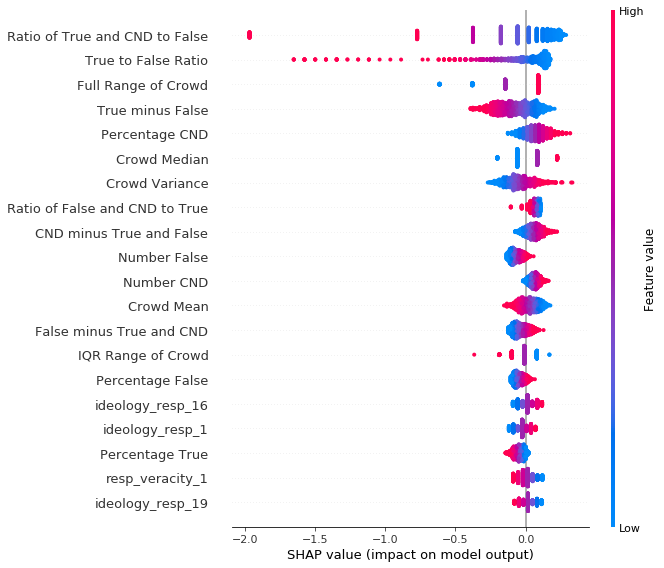

In [27]:
shap.summary_plot(shap_values,  graph_data, show = False)
plt.savefig(figures + 'large_net.pdf', dpi = 300, bbox_inches = 'tight')